## 使用python库

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sbn
sbn.set()

## 参数

In [2]:
# Variable
timesteps = 32
batch_size = 4
units = 32
data_dim = 8
div_class = [-0.003, 0.003]
#div_class = [-0.5, -0.3, -0.1, 0.1, 0.3, 0.5]
num_classes = len(div_class) + 1

## 数据处理

### 数据加载

In [3]:
def data_load():
    data_dir = '../data/'
    day_index1 = data_dir + '1day/index/2000_2009.csv'
    day_index2 = data_dir + '1day/index/2010_2016.csv'
    data1 = pd.read_csv(day_index1,encoding='gbk', parse_dates=['date'])
    data2 = pd.read_csv(day_index2,encoding='gbk', parse_dates=['date'])
    data = pd.concat([data1, data2])
    data.set_index(['code', 'date'], inplace=True)
    return data

### 数据分割

In [4]:
def get_data(data, timesteps, batch_size, query_str):
    match = data.query(query_str)
    min_num = int(batch_size) * int(timesteps) 
    size = len(match)
    m = int(size / min_num)
    if m < 1:
        return None
    
    end_num = min_num * m
    print("data set: {0}:{1} of {2}".format(0, end_num, size))
    result = match.iloc[:end_num, :].copy()

    return result

### 数据清理

In [5]:
def data_clean(data):
    new_data = pd.DataFrame()
    for column in ['open', 'high', 'low', 'close']:
        new_data[column] = data[column] / 10000.0

    # new_data.dropna(inplace=True)
    return new_data

### 数据转换

#### 转换函数

In [6]:
# 阴阳线
def stick_type(x):
    stick_type = -1
    if x['close'] >= x['open']:
        stick_type = 1
    return stick_type

# 上引线
def up_line(x):
    return x['high'] - x[['open','close']].max()

# 下引线
def down_line(x):
    return x[['open','close']].min() - x['low']

# 实体长度
def body_size(x):
    return x['close'] - x['open']

def range_to_class(x):
    cls = []
    size = len(div_class)
    n = -1;
    if x < div_class[0]:
        n = 1
    elif x >= div_class[size-1]:
        n = size + 1
    else:    
        for i in range(0, size-1):
            if div_class[i] <= x < div_class[i+1]:
                n = i + 2
                # print("n=", n)
                break
    if n >= 0:
        for i in range(0, size+1):
            if i == n - 1:
                cls.append(1.0)
            else:
                cls.append(0.0)
    else:
        print(x)
        print("Error: n less than 0")
    return cls

#### 数据转换

In [7]:
def data_transform(data):
    new_data = pd.DataFrame()
    pre_close = data['close'].shift(1)
    for column in ['open', 'high', 'low', 'close']:
        new_data[column] = (data[column] - pre_close) / pre_close
        
    # add new feature
    new_data['stick_type'] = new_data.apply(stick_type, axis=1)
    new_data['up_line'] = new_data.apply(up_line, axis=1)
    new_data['down_line'] = new_data.apply(down_line, axis=1)
    new_data['close_open'] = new_data.apply(body_size, axis=1)
        
    # classes
    new_data['class'] = new_data['close'].shift(-1)
    # new_data.dropna(inplace=True)
    new_data.fillna(0, inplace=True)
    new_data['class']= new_data['class'].map(range_to_class)
        
    # new_data.dropna(inplace=True)
    return new_data

### 数据标准化

In [8]:
def normalize(data):
    columns = ['open', 'high', 'low', 'close', 'stick_type', 'up_line', 'down_line', 'close_open']
    for column in columns:
        data[column] = data[column] * 100
    return data

### 数据重整

In [9]:
def data_reform(data, batch_size, timesteps):
    print("shape: {0}".format(data.shape))
    size = len(data)
    if size % (int(batch_size) * int(timesteps)) != 0:
        print("data size not match, size: {0}, batch_size: {1}, timesteps: {2}".format(size, batch_size, timesteps))
        return None, None
   
    X, Y0 = data[:, :-1], data[:, -1]
    
    X = X.reshape((-1, timesteps, X.shape[1]))
    
    Y = np.array([np.array(y) for y in Y0])
    
    Y = Y.reshape((-1, timesteps, Y.shape[1]))
    
    print("X.shape: {0} Y.shape: {1}".format(X.shape, Y.shape))
    
    return X, Y

## 数据分析

In [10]:
data_all = data_load()

In [11]:
idx_dict = {'上证50': 999987, '沪深300': 300, '中证500': 990905, '中小板指': 399005, '创业板指': 399006}

In [12]:
# 确认指数代码
for idx_name in idx_dict:
    print("name: {0}".format(idx_name))
    Id = data_all[data_all['name'] == idx_name].index.get_level_values('code').unique()
    print("Id: {0}".format(Id))

name: 中小板指
Id: Int64Index([399005, 399329], dtype='int64', name='code')
name: 创业板指
Id: Int64Index([399006], dtype='int64', name='code')
name: 上证50
Id: Int64Index([999987], dtype='int64', name='code')
name: 沪深300
Id: Int64Index([300, 399300], dtype='int64', name='code')
name: 中证500
Id: Int64Index([990905, 999905], dtype='int64', name='code')


In [13]:
years = pd.date_range('1/1/2006', periods=11, freq='A')

In [14]:
def data_stat(data, years, idx_dict):
    idxes_des = pd.DataFrame()
    for name in idx_dict:
        # print(name)
        code = idx_dict[name]
        query_code = 'code=={0}'.format(code)
        # print("query code: {0}".format(query_code))
        data_code = data.query(query_code)
        data_code_c = data_clean(data_code)
        data_code_t = data_transform(data_code_c)
        idx_des = pd.DataFrame()
        for year in years:
            end_date = year
            begin_date  = year.replace(month=1, day=1)
            query_date = 'date>"{0}" & date < "{1}"'.format(begin_date, end_date)
            # print("query date: {0}".format(query_date))
            data_code_year = data_code_t.query(query_date)
            describe = data_code_year.close.describe()
            df_describe = describe.to_frame().reset_index()
            df_describe['date'] = year
            idx_des = pd.concat([idx_des, df_describe])
        idx_des = idx_des.pivot(index='date', columns='index', values='close')    
        idx_des['code'] = code
        idxes_des = pd.concat([idxes_des, idx_des])
    return idxes_des

In [15]:
data_stat = data_stat(data_all, years, idx_dict)

In [16]:
data_stat_d = data_stat.drop(['count', 'min', 'max', 'std'],axis=1).dropna()

<IPython.core.display.Javascript object>


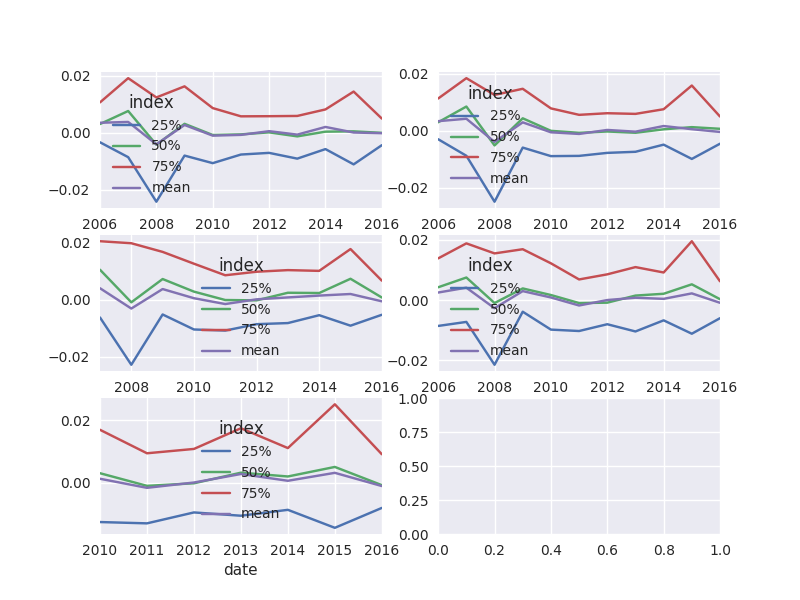

In [17]:
t = data_stat_d.reset_index().set_index(['code', 'date'])
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 6))
t.loc[999987].plot(ax=axes[0, 0])
t.loc[300].plot(ax=axes[0, 1])
t.loc[990905].plot(ax=axes[1, 0])
t.loc[399005].plot(ax=axes[1, 1])
t.loc[399006].plot(ax=axes[2, 0])

## 模型

In [18]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Activation


model = Sequential()
# input layer
# activation='relu' 
# dropout=0.5
# kernel_initializer="uniform"
model.add(LSTM(units, stateful=True, return_sequences=True, batch_input_shape=(batch_size, timesteps, data_dim), kernel_initializer="uniform"))
# hidden layer
model.add(LSTM(units, return_sequences=True, stateful=True, dropout=0.5, kernel_initializer="uniform"))
model.add(LSTM(units, return_sequences=True, stateful=True, dropout=0.5, kernel_initializer="uniform"))
model.add(LSTM(units, return_sequences=True, stateful=True, dropout=0.5, kernel_initializer="uniform"))

# 回归问题
# # output layer
# # model.add(Dense(no_classes, activation='softmax'))
# model.add(Dense(1, activation='sigmoid')) # or sigmoid?
# # model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='RMSProp', loss='mse') #mse

# 分类问题
# output layer
model.add(Dense(num_classes, activation='softmax'))
# model.add(Dense(num_classes, kernel_initializer="uniform"))
# model.add(BatchNormalization())
# model.add(Activation('softmax'))

from keras.optimizers import SGD, Adam, RMSprop
model.compile(optimizer=RMSprop(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (4, 32, 32)               5248      
_________________________________________________________________
lstm_2 (LSTM)                (4, 32, 32)               8320      
_________________________________________________________________
lstm_3 (LSTM)                (4, 32, 32)               8320      
_________________________________________________________________
lstm_4 (LSTM)                (4, 32, 32)               8320      
_________________________________________________________________
dense_1 (Dense)              (4, 32, 3)                99        
Total params: 30,307
Trainable params: 30,307
Non-trainable params: 0
_________________________________________________________________


## 数据集

### 测试集

In [29]:
def get_data_set(data, codes, date_query, timesteps, batch_size):
    test_set = {}
    for code in codes:
        query_str = 'code=={0} & {1}'.format(code, date_query)
        data_match = get_data(data, timesteps, batch_size, query_str)
        data_cleaned = data_clean(data_match)
        data_transformed = data_transform(data_cleaned)
        print(data_transformed.index[0])
        print(data_transformed.index[-1])
        test_set[code] = data_transformed
    return test_set

In [30]:
test_codes = ['990905', '999987']
test_date_query = 'date>"20141120"'

In [31]:
raw_test_set = get_data_set(data_all, test_codes, test_date_query, timesteps, batch_size)

data set: 0:512 of 517
(990905, Timestamp('2014-11-21 00:00:00'))
(990905, Timestamp('2016-12-23 00:00:00'))
data set: 0:512 of 517
(999987, Timestamp('2014-11-21 00:00:00'))
(999987, Timestamp('2016-12-23 00:00:00'))


In [32]:
raw_test_set['999987'].tail(5)

open      high       low     close  stick_type  \
code   date                                                             
999987 2016-12-19 -0.001130  0.000595 -0.006086 -0.004748          -1   
       2016-12-20  0.000880  0.001628 -0.012441 -0.005107          -1   
       2016-12-21  0.001071  0.010930  0.001015  0.007759           1   
       2016-12-22 -0.001751  0.000356 -0.007218 -0.002320          -1   
       2016-12-23 -0.000781 -0.000139 -0.009124 -0.005918          -1   

                    up_line  down_line  close_open            class  
code   date                                                          
999987 2016-12-19  0.001725   0.001339   -0.003618  [1.0, 0.0, 0.0]  
       2016-12-20  0.000748   0.007334   -0.005986  [0.0, 0.0, 1.0]  
       2016-12-21  0.003171   0.000056    0.006688  [0.0, 1.0, 0.0]  
       2016-12-22  0.002107   0.004899   -0.000569  [1.0, 0.0, 0.0]  
       2016-12-23  0.000642   0.003206   -0.005136  [0.0, 1.0, 0.0]

In [33]:
test_set = {}
for code in raw_test_set:
    test_set[code] = data_reform(normalize(raw_test_set[code]).values, batch_size, timesteps)

shape: (512, 9)
X.shape: (16, 32, 8) Y.shape: (16, 32, 3)
shape: (512, 9)
X.shape: (16, 32, 8) Y.shape: (16, 32, 3)


In [41]:
idxes = data_all.index.get_level_values('code').unique()

### 训练集

In [35]:
train_map = {'上证50': 999987, '沪深300': 300, '中证500': 990905, '中小板指': 399005, '创业板指': 399006}

In [36]:
# train sets
train_codes = []
for key in train_map:
    train_codes.append(train_map[key])
    
train_date_query = 'date<"20150101"'

raw_train_set = get_data_set(data_all, train_codes, train_date_query, timesteps, batch_size)

data set: 0:2048 of 2171
(399005, Timestamp('2006-01-24 00:00:00'))
(399005, Timestamp('2014-07-03 00:00:00'))
data set: 0:1024 of 1113
(399006, Timestamp('2010-06-01 00:00:00'))
(399006, Timestamp('2014-08-20 00:00:00'))
data set: 0:2560 of 2670
(999987, Timestamp('2004-01-02 00:00:00'))
(999987, Timestamp('2014-07-22 00:00:00'))
data set: 0:2304 of 2360
(300, Timestamp('2005-04-08 00:00:00'))
(300, Timestamp('2014-10-14 00:00:00'))
data set: 0:1920 of 1928
(990905, Timestamp('2007-01-26 00:00:00'))
(990905, Timestamp('2014-12-19 00:00:00'))


In [37]:
raw_train_set[300].head()

open      high       low     close  stick_type   up_line  \
code date                                                                       
300  2005-04-08  0.000000  0.000000  0.000000  0.000000          -1  0.000000   
     2005-04-11  0.000433  0.005272 -0.010635 -0.007996          -1  0.004839   
     2005-04-12 -0.001718 -0.001718 -0.017296 -0.016801          -1  0.000000   
     2005-04-13  0.009454  0.028407  0.009454  0.022686           1  0.005721   
     2005-04-14  0.003737  0.005511 -0.015308 -0.013912          -1  0.001774   

                 down_line  close_open            class  
code date                                                
300  2005-04-08   0.000000    0.000000  [1.0, 0.0, 0.0]  
     2005-04-11   0.002639   -0.008429  [1.0, 0.0, 0.0]  
     2005-04-12   0.000495   -0.015083  [0.0, 0.0, 1.0]  
     2005-04-13   0.000000    0.013232  [1.0, 0.0, 0.0]  
     2005-04-14   0.001396   -0.017649  [1.0, 0.0, 0.0]

In [38]:
train_set = {}
for code in raw_train_set:
    train_set[code] = data_reform(normalize(raw_train_set[code]).values, batch_size, timesteps)

shape: (1920, 9)
X.shape: (60, 32, 8) Y.shape: (60, 32, 3)
shape: (2560, 9)
X.shape: (80, 32, 8) Y.shape: (80, 32, 3)
shape: (2304, 9)
X.shape: (72, 32, 8) Y.shape: (72, 32, 3)
shape: (2048, 9)
X.shape: (64, 32, 8) Y.shape: (64, 32, 3)
shape: (1024, 9)
X.shape: (32, 32, 8) Y.shape: (32, 32, 3)


## 训练

### 绘图

In [29]:
init_y = 1
init_x = 10
lines = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

<IPython.core.display.Javascript object>


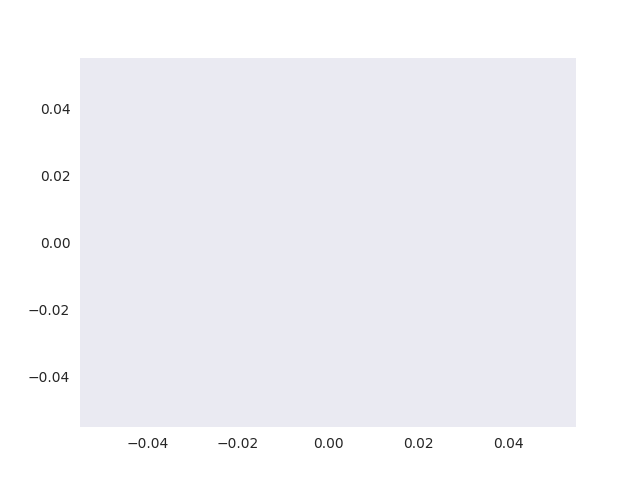

In [30]:
fig, ax = plt.subplots()
for key in lines:
    xdata, ydata = [], []
    line, = ax.plot(xdata, ydata, lw=2)
    lines[key] = [line, xdata, ydata]
ax.grid()

In [31]:
def init():
    ax.set_ylim(0, init_y)
    ax.set_xlim(0, init_x)

In [32]:
'test_loss' in lines

True

In [33]:
def run(data):
    # update the data  
    for key in data:
        if key in lines:
            lines[key][1].append(data[key][0])
            lines[key][2].append(data[key][1])
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()

            if data[key][0] >= xmax:
                ax.set_xlim(xmin, 1.3*data[key][0])
            if data[key][0] < xmin:
                ax.set_xlim(data[key][0], xmax)
                
            if data[key][1] >= ymax:
                ax.set_ylim(ymin, 1.3*data[key][1])
            if data[key][1] < ymin:
                ax.set_ylim(data[key][1], ymax)
                
            ax.figure.canvas.draw()
            lines[key][0].set_data(lines[key][1], lines[key][2])
        else:
            print('not found key: {0}'.format(key))

In [34]:
# run({'train_loss': (1, 1.0738436778386433), 'train_acc': (1, 0.45885416666666667)})

In [35]:
# def init():
#     ax.set_ylim(-1.1, 1.1)
#     ax.set_xlim(0, 10)
#     del xdata[:]
#     del ydata[:]
#     line.set_data(xdata, ydata)
#     return line,

# fig, ax = plt.subplots()
# line, = ax.plot([], [], lw=2)
# ax.grid()
# xdata, ydata = [], []


# def run(data):
#     # update the data
#     t, y = data
#     xdata.append(t)
#     ydata.append(y)
#     xmin, xmax = ax.get_xlim()

#     if t >= xmax:
#         ax.set_xlim(xmin, 2*xmax)
#         ax.figure.canvas.draw()
#     line.set_data(xdata, ydata)

#     return line,

# # ani = animation.FuncAnimation(fig, run, data_gen, repeat=False, init_func=init)
# # plt.show()

In [43]:
epochs =2000
def train(model, train_set, test_set, epochs, batch_size):
# def train():
    for e in range(epochs):
        for code in train_set:
            print("epochs: {0}, code: {1}".format(e, code))
            train_X, train_Y = train_set[code]
            # print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
            # history = model.fit(train_X, train_Y, epochs=100, batch_size=batch_size, validation_data=(test_X, test_Y), verbose=1, shuffle=False)
            history = model.fit(train_X, train_Y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
            model.reset_states()  
            result = {'code': code, 'train_loss': (e, history.history['loss'][-1]), 'train_acc': (e, history.history['acc'][-1])}
            print(result)
            # yield result
        for code in test_set:
            test_X1, test_Y1 = test_set[code]
            loss_and_metrics = model.evaluate(test_X1, test_Y1, batch_size=batch_size)
            model.reset_states()
            result = {'code': code, 'test_loss': (e, loss_and_metrics[0]), 'test_acc': (e, loss_and_metrics[1])}
            print(result)
            # yield result
                # print("==================================")
                # print("loss_and_metrics: {0}".format(loss_and_metrics))
                # print("==================================")

#     def data_gen(t=0):
#         cnt = 0
#         while cnt < 1000:
#             cnt += 1
#             t += 0.1
#             yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)
# ani = animation.FuncAnimation(fig, run, train, repeat=False, init_func=init)
# plt.show()


In [44]:
train(model, train_set, test_set, epochs, batch_size)

epochs: 0, code: 990905
{'train_loss': (0, 1.0828673283259074), 'train_acc': (0, 0.39947916666666666), 'code': 990905}
epochs: 0, code: 999987
{'train_loss': (0, 1.063594251871109), 'train_acc': (0, 0.38203124999999999), 'code': 999987}
epochs: 0, code: 300
{'train_loss': (0, 1.0621697240405612), 'train_acc': (0, 0.39973958333333331), 'code': 300}
epochs: 0, code: 399005
{'train_loss': (0, 1.0303703136742115), 'train_acc': (0, 0.47412109375), 'code': 399005}
epochs: 0, code: 399006
{'train_loss': (0, 1.015991248190403), 'train_acc': (0, 0.4580078125), 'code': 399006}
 4/16 [======>.......................] - ETA: 0s{'test_acc': (0, 0.408203125), 'test_loss': (0, 1.087430864572525), 'code': '999987'}
epochs: 1, code: 990905
{'train_loss': (1, 1.0043264230092366), 'train_acc': (1, 0.49010416666666667), 'code': 990905}
epochs: 1, code: 999987
{'train_loss': (1, 1.0676014482975007), 'train_acc': (1, 0.40000000000000002), 'code': 999987}
epochs: 1, code: 300
{'train_loss': (1, 1.061116837792

KeyboardInterrupt: 

In [ ]:
# def data_gen(t=0):
#     cnt = 0
#     while cnt < 1000:
#         cnt += 1
#         t += 0.1
#         yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)

In [ ]:
# ani = animation.FuncAnimation(fig, run, data_gen, repeat=False, init_func=init)
# plt.show()

In [ ]:
# train(model, train_set, test_set, 100, batch_size)

In [ ]:
plt.show()

In [ ]:
train()

In [ ]:
# history = model.fit(train_X, train_Y, epochs=100, batch_size=batch_size, validation_data=(test_X, test_Y), verbose=1, shuffle=False)

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [ ]:
predict_Y=model.predict(x=test_X1,batch_size=batch_size)

In [ ]:
predict_Y.shape

In [ ]:
predict_value = np.argmax(predict_Y,axis=2)

In [ ]:
predict_value.shape

In [ ]:
test_set = idx300n.iloc[1800:2400, :].copy()

In [ ]:
test_t2.head()

In [ ]:
def class_argmax(x):
    return np.argmax(x)

In [ ]:
test_set = test_t1

In [ ]:
test_set['class']= test_set['class'].map(class_argmax)

In [ ]:
test_set.head()

In [ ]:
cmp_predict = pd.DataFrame()
cmp_predict['class'] = test_set['class']

In [ ]:
cmp_predict['predict_class'] = predict_value.reshape((-1, ))

In [ ]:
cmp_predict['close'] = test_t2.loc[cmp_predict.index, 'close']

In [ ]:
cmp_predict['diff'] = cmp_predict['predict_class'] - cmp_predict['class']

In [ ]:
cmp_predict.head()

In [ ]:
cmp_predict=cmp_predict.reset_index()

In [ ]:
cmp_predict = cmp_predict.reset_index()

In [ ]:
cmp_predict.head()

In [ ]:
def color(x):
    c = 'm'
    if x < 0:
        c = 'g'
    elif x > 0:
        c = 'r'
    else:
        c = 'b'
    return c
cmp_predict['color'] = cmp_predict['diff'].map(color)

In [ ]:
cmp_predict.plot(kind='scatter', x='index', y='close', s=60, c=cmp_predict.color, figsize=(21, 7))

In [ ]:
test_t2['close'].head(600).plot.hist( bins=30, figsize=(21, 7))

In [ ]:
cmp_predict.tail()

In [ ]:
cmp_predict['predict_class'].plot.hist()

In [ ]:
cmp_predict['class'].plot.hist()

In [ ]:
cmp_predict['next_close'] = cmp_predict['close'].shift(-1)

In [ ]:
cmp_predict['profit'] = cmp_predict['next_close'] - cmp_predict['close']

In [ ]:
cmp_predict.head()

In [ ]:
def predict_profit(x):
    profit = 0
    if x['predict_class'] == 2:
        profit = x['profit']
    elif x['predict_class'] == 0:
        profit = -x['profit']
    else:
        profit = 0
    return profit
cmp_predict['predict_profit'] = cmp_predict.apply(predict_profit, axis=1)

In [ ]:
cmp_predict['predict_profit'].cumsum().plot(figsize=(21, 7))

In [ ]:
cmp_predict.head(400).tail()

In [ ]:
cmp_predict.head()

In [ ]:
cmp_predict[cmp_predict['predict_class']==2]['predict_profit'].cumsum().plot(figsize=(21, 7))

In [ ]:
cmp_predict[cmp_predict['predict_class']==0]['predict_profit'].cumsum().plot(figsize=(21, 7))

## 性能评估

### 类预测比较

### 类分布

In [ ]:
# column: true_class predict_class
def class_compare(df):
    return pd.crosstab(df.true_class, df.predict_class, margins=True) 

### 利润

In [ ]:
# column: close signal
def portfolio_return_ration(df, direction="both"):
    def profit(x):
        # 归一化
        x[x['signal'] < -1]['signal'] = -1
        x[x['signal'] > 1]['signal'] = 1

        if direction == "long":
            x[x['signal'] < 0]['signal'] = 0
        elif direction == "short":
            x[x['signal'] > 0]['signal'] = 0
            
        x['profit'] = x['diff'] * x['signal']
        return x

    df_tmp = pd.DataFrame()
    pre_close = df['close'].shift(1)
    df_tmp['diff'] =  df['close'] - pre_close
    df_tmp['signal'] = df['signal']
    
    df_tmp['profit'] = df.apply(profit, axis=1)
    return (df_tmp['profit']+1).cumprod()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 20, 100)
y = np.sin(x)
z = x + 20 * y

scaled_z = (x - x.min())
colors = plt.cm.coolwarm(x)

plt.scatter(x, y, marker='+', edgecolors=colors, s=150, linewidths=4)
plt.show()